In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import scipy.signal
from datetime import timezone

sns.set_palette('cubehelix')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
with open('pickles/may_2018_with_counts.pickle', 'rb') as pik:
    data = pickle.load(pik)
    
df = pd.DataFrame(data)

In [3]:
df['WEEKDAY_NUM'] = [day.weekday() for day in df.DATETIME]

In [4]:
df.head()

,C/A,UNIT,SCP,STATION,DIVISION,DATE,DESC,ENTRIES,EXITS,DATETIME,WEEKDAY,ENTRY_COUNTS,EXIT_COUNTS,TOTAL_ACTIVITY,WEEKDAY_NUM
0,A002,R051,02-00-00,59 ST,BMT,04/28/2018,REGULAR,6598847,2235829,2018-04-28 00:00:00,Saturday,NaN,NaN,NaN,5
1,A002,R051,02-00-00,59 ST,BMT,04/28/2018,REGULAR,6598864,2235830,2018-04-28 04:00:00,Saturday,17.0,1.0,18.0,5
2,A002,R051,02-00-00,59 ST,BMT,04/28/2018,REGULAR,6598880,2235863,2018-04-28 08:00:00,Saturday,16.0,33.0,49.0,5
3,A002,R051,02-00-00,59 ST,BMT,04/28/2018,REGULAR,6598961,2235955,2018-04-28 12:00:00,Saturday,81.0,92.0,173.0,5
4,A002,R051,02-00-00,59 ST,BMT,04/28/2018,REGULAR,6599175,2236015,2018-04-28 16:00:00,Saturday,214.0,60.0,274.0,5


### Plot Total Activity By Weekday

In [5]:
# Creates table grouped by weekday
df.sort_values('WEEKDAY_NUM', inplace=True)
weekdays = df.groupby(['WEEKDAY_NUM','WEEKDAY']).sum()
weekdays.reset_index(inplace = True)

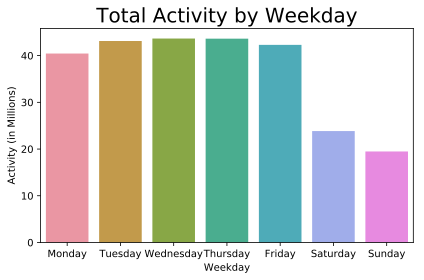

In [13]:
# Plots total activity by weekday
sns.barplot(x = 'WEEKDAY', y = 'TOTAL_ACTIVITY', data = weekdays)

plt.title('Total Activity by Weekday', {'fontsize': 20})
plt.xlabel('Weekday')
plt.ylabel('Activity (in Millions)')
plt.yticks(list(range(0,50000000,10000000)),['0','10','20','30','40'])
plt.tight_layout()
plt.savefig('presentation/figures/activity_by_weekday.svg')
plt.show()

### Plot Frequency Of Busiest Days For Busiest Stations

In [7]:
# Creates table with one weekday row for each station
df.sort_values(['STATION','WEEKDAY_NUM'], inplace=True)
stations_by_weekday = df.groupby(['STATION','WEEKDAY_NUM','WEEKDAY']).sum()
stations_by_weekday.reset_index(inplace=True)

In [8]:
# Sorts this table by activity to get busiest day for each station at top and extracts that row
stations_by_weekday.sort_values(['STATION','TOTAL_ACTIVITY'], ascending=False, inplace=True)
stations_by_weekday = stations_by_weekday.groupby('STATION').first()
stations_by_weekday.sort_values('TOTAL_ACTIVITY', ascending=False, inplace = True)

In [9]:
# Extracts the 100 busiest stations
stations_by_weekday_busiest = stations_by_weekday.head(100)
stations_by_weekday_busiest = stations_by_weekday_busiest.groupby(['WEEKDAY_NUM','WEEKDAY']).count()
stations_by_weekday_busiest.reset_index(inplace = True)

In [10]:
# Sorts the new table by days of the week
stations_by_weekday_busiest.sort_values(['WEEKDAY_NUM'], inplace=True)
stations_by_weekday_busiest.set_index(['WEEKDAY_NUM'],inplace=True)

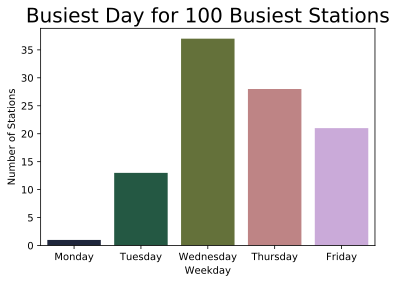

In [12]:
# Plots busiest day for busiest stations
sns.barplot(x = 'WEEKDAY', y = 'TOTAL_ACTIVITY', data=stations_by_weekday_busiest)

plt.xlabel('Weekday')
plt.ylabel('Number of Stations')
plt.title('Busiest Day for 100 Busiest Stations', fontdict={'fontsize': 20})

plt.savefig('presentation/figures/busiest_days.svg')
plt.show()

### Exploratory Plots For 10 Busiest Stations By Entries, Exits, And Activity

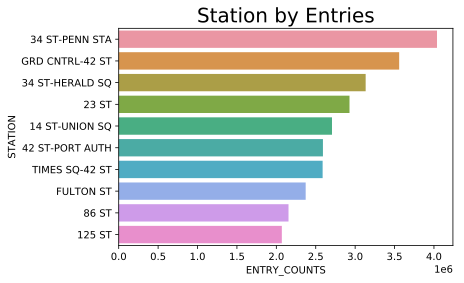

In [14]:
# total values over May
dfstat = df.groupby('STATION').sum()

# identify the top 10 trafficked station by entries
top10entries = dfstat.sort_values('ENTRY_COUNTS', ascending=False)[['ENTRY_COUNTS']]\
                    .head(10).reset_index()

# Stations by Entries
sns.barplot(y = 'STATION', x = 'ENTRY_COUNTS', data=top10entries, orient='h');
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='x');
plt.title('Station by Entries', fontdict={'fontsize': 20});

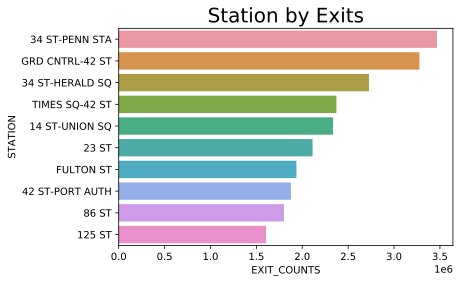

In [15]:
# identify the top 10 stations by exits
top10exits = dfstat.sort_values('EXIT_COUNTS', ascending=False)[['EXIT_COUNTS']]\
                    .head(10).reset_index()

sns.barplot(y = 'STATION', x = 'EXIT_COUNTS', data=top10exits, orient='h');
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='x');
plt.title('Station by Exits', fontdict={'fontsize': 20});

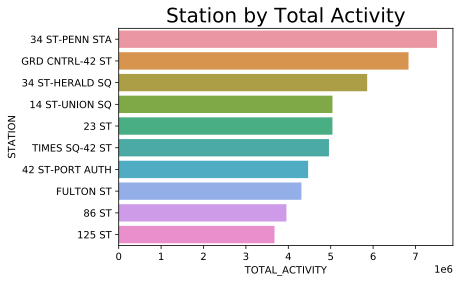

In [16]:
top10active = dfstat.sort_values('TOTAL_ACTIVITY', ascending=False)[['TOTAL_ACTIVITY']]\
                    .head(10).reset_index()

sns.barplot(y = 'STATION', x = 'TOTAL_ACTIVITY', data=top10active, orient='h');
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='x');
plt.title('Station by Total Activity', fontdict={'fontsize': 20});

### Plots Busiest Stations For Weekends Vs Weekdays

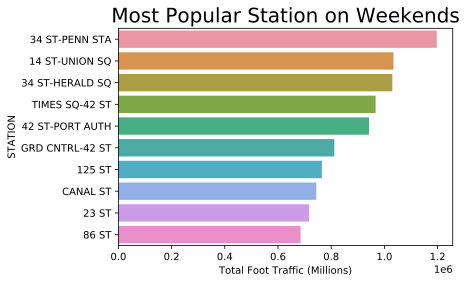

In [18]:
# what are the most popular stations on Weekends?

mask = ((df['WEEKDAY'] == 'Saturday') | (df['WEEKDAY'] == 'Sunday'))

df_weekend = df[mask]
df_weekend_sort = df_weekend.groupby('STATION')[['TOTAL_ACTIVITY']].sum()\
                            .sort_values('TOTAL_ACTIVITY', ascending=False)
df_weekend_sort.reset_index(inplace=True)
# plot most popular stations on weekend

sns.set_palette('cubehelix')

sns.barplot(y = 'STATION', x = 'TOTAL_ACTIVITY', data=df_weekend_sort.head(10), orient='h');
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='x');
plt.title('Most Popular Station on Weekends', fontdict={'fontsize': 20});
plt.xlabel('Total Foot Traffic (Millions)')
plt.savefig('presentation/figures/Most_Popular_Weekends.svg')
plt.show()

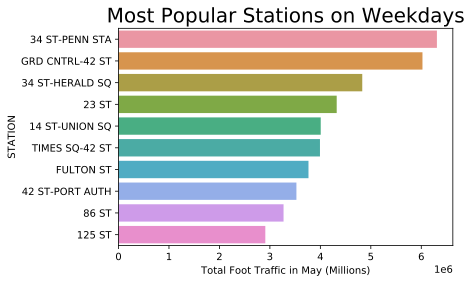

In [19]:
mask = ((df['WEEKDAY'] == 'Monday')|\
       (df['WEEKDAY'] == 'Tuesday')|\
       (df['WEEKDAY'] == 'Wednesday')|\
       (df['WEEKDAY'] == 'Thursday')|\
       (df['WEEKDAY'] == 'Friday'))

df_weekday = df[mask]
df_weekday_sort = df_weekday.groupby('STATION')[['TOTAL_ACTIVITY']].sum()\
                            .sort_values('TOTAL_ACTIVITY', ascending=False)
df_weekday_sort.reset_index(inplace=True)

# plot most popular stations on weekdays
sns.barplot(y = 'STATION', x = 'TOTAL_ACTIVITY', data=df_weekday_sort.head(10), orient='h');
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='x');
plt.title('Most Popular Stations on Weekdays', fontdict={'fontsize': 20});
plt.xlabel('Total Foot Traffic in May (Millions)');
plt.savefig('presentation/figures/Most_Popular_Weekdays.svg')
plt.show()

### Plot For Busiest Stations On Busiest Days

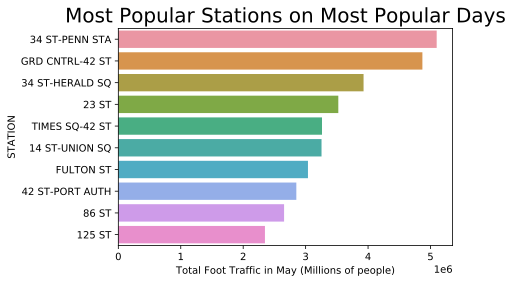

In [21]:
mask = (df['WEEKDAY'].isin(['Tuesday', 'Wednesday', 'Thursday', 'Friday']))

dftopdays = df[mask]
dftopdays_sort = dftopdays.groupby('STATION')[['TOTAL_ACTIVITY']].sum()\
                            .sort_values('TOTAL_ACTIVITY', ascending=False)

dftopdays_sort.reset_index(inplace=True)

sns.barplot(y = 'STATION', x = 'TOTAL_ACTIVITY', data=dftopdays_sort.head(10), orient='h');
plt.ticklabel_format(style='sci', scilimits=(0,0), axis='x');
plt.title('Most Popular Stations on Most Popular Days', fontdict={'fontsize': 20});
plt.xlabel('Total Foot Traffic in May (Millions of people)')
plt.savefig('presentation/figures/Popular_Stations_Popular_Days.svg')
plt.show()

### Plots Activity By Time For Penn Sation For One Week

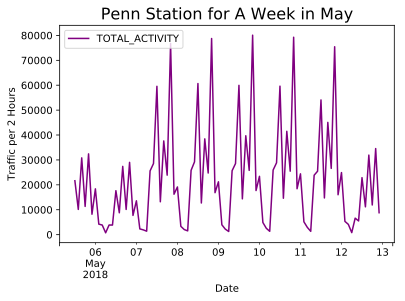

In [22]:
# plot penn by time

penn = df[df['STATION'] == '34 ST-PENN STA'].groupby(['DATETIME']).sum().reset_index()

font = {'family': 'sans',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

penn.iloc[90:180].plot(x='DATETIME', y='TOTAL_ACTIVITY', kind='line', c='purple');
plt.title('Penn Station for A Week in May', fontdict=font)
plt.ylabel('Traffic per 2 Hours')
plt.xlabel('Date')
plt.savefig('presentation/figures/Penn_Station_line.svg')
plt.show()

/Users/Stephen/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


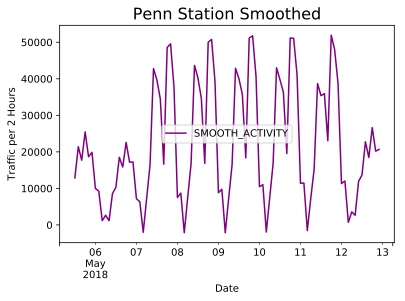

In [23]:
x = [dt.replace(tzinfo=timezone.utc).timestamp() for dt in penn['DATETIME']]
y = penn['TOTAL_ACTIVITY']

smooth_data = scipy.signal.savgol_filter(x=y, window_length=7, polyorder=5)
penn['SMOOTH_ACTIVITY'] = smooth_data

penn.iloc[90:180].plot(x='DATETIME', y='SMOOTH_ACTIVITY', kind='line', c='purple');
plt.title('Penn Station Smoothed', fontdict=font)
plt.ylabel('Traffic per 2 Hours')
plt.xlabel('Date')
plt.savefig('presentation/figures/Penn_Station_line_smooth.svg')
plt.show()